# GraphSage Baseline for Product Categorization
## ML4G Course Project - Applications Research with GNNs

**Team:** Abhishek Indupally, Pranav Bhimrao Kapadne, Gaurav Suvarna

**Goal:** Implement Graph Convolutional Network (GraphSage) as baseline GNN to compare against MLP

**Dataset:** ogbn-products with 15 selected product categories (excluding label 4)

## 1. Imports and Setup

In [1]:
from ogb.nodeproppred import PygNodePropPredDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.serialization import add_safe_globals
from torch_geometric.data import Data, Batch
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage, NodeStorage, EdgeStorage
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.7.1+cu118
CUDA available: True


In [2]:
# Allowlist required torch_geometric classes for safe unpickling
add_safe_globals([DataEdgeAttr, DataTensorAttr, GlobalStorage, NodeStorage, EdgeStorage, Data, Batch])

In [3]:
# ===== LOAD BASELINE RESULTS FOR COMPARISON =====

mlp_results = None
gcn_results = None
mlp_available = False
gcn_available = False

# Try to load MLP results
if os.path.exists('mlp_500k_results.json'):
    try:
        with open('mlp_500k_results.json', 'r') as f:
            mlp_results = json.load(f)
        mlp_available = True
        print("✅ MLP baseline results loaded from mlp_500k_results.json")
        print(f"   MLP Test Accuracy: {mlp_results['test_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"⚠️  Could not load MLP results: {e}")
else:
    print("⚠️  mlp_500k_results.json not found")

# Try to load GCN results
if os.path.exists('gcn_results.json'):
    try:
        with open('gcn_results.json', 'r') as f:
            gcn_results = json.load(f)
        gcn_available = True
        print("✅ GCN baseline results loaded from gcn_results.json")
        print(f"   GCN Test Accuracy: {gcn_results['test_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"⚠️  Could not load GCN results: {e}")
else:
    print("⚠️  gcn_results.json not found")

print("\n" + "="*60)
if mlp_available and gcn_available:
    print("✅ Ready to compare: MLP vs GCN vs GraphSAGE")
elif mlp_available or gcn_available:
    print("⚠️  Partial comparison available")
else:
    print("⚠️  No baseline results found - run MLP and GCN first")
print("="*60)

✅ MLP baseline results loaded from mlp_500k_results.json
   MLP Test Accuracy: 61.92%
✅ GCN baseline results loaded from gcn_results.json
   GCN Test Accuracy: 76.68%

✅ Ready to compare: MLP vs GCN vs GraphSAGE


## 2. Load Dataset and Graph Structure

Unlike MLP which only used node features, GraphSage will use the full graph structure (edges).

In [4]:
# Load dataset
print("Loading ogbn-products dataset...")
dataset = PygNodePropPredDataset(name="ogbn-products", root="data")
data = dataset[0]

print("\n" + "="*60)
print("ORIGINAL DATASET INFO")
print("="*60)
print(f"Total nodes: {data.x.shape[0]:,}")
print(f"Node features: {data.x.shape[1]}")
print(f"Total edges: {data.edge_index.shape[1]:,}")
print(f"Labels shape: {data.y.shape}")
print(f"All unique labels: {torch.unique(data.y).numel()}")

Loading ogbn-products dataset...

ORIGINAL DATASET INFO
Total nodes: 2,449,029
Node features: 100
Total edges: 123,718,280
Labels shape: torch.Size([2449029, 1])
All unique labels: 47


## 2.5 Subsample for GPU Memory Constraints

**GPU Status:** 7.22 GiB free out of 11.90 GiB total

**Strategy:** Subsample to ~500K nodes to use ~5-6GB (safe buffer)

**Full dataset would require:** ~34GB (too large for available 7GB)

**Note:** This maximizes use of available GPU while maintaining stability.

In [5]:
# ===== SUBSAMPLE FOR GPU MEMORY =====
print("\n" + "="*60)
print("SUBSAMPLING DATASET FOR GPU MEMORY")
print("="*60)

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Subsample to 500K nodes to use available 7GB GPU memory efficiently
# You have 7.22 GiB free - this should use ~5-6GB (safe buffer)
subsample_size = 500000

# Random sample
total_nodes = data.x.shape[0]
sampled_indices = torch.randperm(total_nodes)[:subsample_size]
sampled_indices = sampled_indices.sort()[0]  # Sort for efficiency

print(f"Original dataset: {total_nodes:,} nodes")
print(f"Subsampled to: {len(sampled_indices):,} nodes")
print(f"Subsampling ratio: {100*len(sampled_indices)/total_nodes:.1f}%")
print(f"Target GPU usage: ~5-6GB out of 7.22GB available")

# Create mapping from old indices to new indices for this subsample
subsample_mapping = {}
for new_idx, old_idx in enumerate(sampled_indices):
    subsample_mapping[old_idx.item()] = new_idx

# Extract subgraph
print("\nExtracting subgraph...")
from torch_geometric.utils import subgraph as pyg_subgraph

subsampled_edge_index, _ = pyg_subgraph(
    subset=sampled_indices,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=total_nodes
)

# Update data object with subsampled data
data.x = data.x[sampled_indices]
data.y = data.y[sampled_indices]
data.edge_index = subsampled_edge_index

print(f"Edges after subsampling: {data.edge_index.shape[1]:,}")
print(f"Edge retention: {100*data.edge_index.shape[1]/123718280:.1f}%")
print("\n✅ Subsampling complete! Dataset optimized for 7GB available GPU memory.")
print("="*60)


SUBSAMPLING DATASET FOR GPU MEMORY
Original dataset: 2,449,029 nodes
Subsampled to: 500,000 nodes
Subsampling ratio: 20.4%
Target GPU usage: ~5-6GB out of 7.22GB available

Extracting subgraph...
Edges after subsampling: 5,167,660
Edge retention: 4.2%

✅ Subsampling complete! Dataset optimized for 7GB available GPU memory.


## 3. Load Sales Ranking Splits

Using the same splits as MLP baseline for fair comparison.

In [6]:
# Load custom splits from CSV files (sales_ranking strategy)
split_dir = "data/ogbn_products/split/sales_ranking/"
train_df = pd.read_csv(split_dir + "train.csv.gz")
valid_df = pd.read_csv(split_dir + "valid.csv.gz")
test_df = pd.read_csv(split_dir + "test.csv.gz")

# Get original split indices
original_train = torch.tensor(train_df.iloc[:, 0].values, dtype=torch.long)
original_valid = torch.tensor(valid_df.iloc[:, 0].values, dtype=torch.long)
original_test = torch.tensor(test_df.iloc[:, 0].values, dtype=torch.long)

print("\nOriginal split sizes (before subsampling):")
print(f"  Train: {len(original_train):,}")
print(f"  Valid: {len(original_valid):,}")
print(f"  Test: {len(original_test):,}")

# Filter splits to only include nodes in our subsample
# Remember: sampled_indices contains the original indices that were kept
train_in_sample = torch.isin(original_train, sampled_indices)
valid_in_sample = torch.isin(original_valid, sampled_indices)
test_in_sample = torch.isin(original_test, sampled_indices)

filtered_train_original = original_train[train_in_sample]
filtered_valid_original = original_valid[valid_in_sample]
filtered_test_original = original_test[test_in_sample]

print("\nSplit sizes after subsampling:")
print(f"  Train: {len(filtered_train_original):,}")
print(f"  Valid: {len(filtered_valid_original):,}")
print(f"  Test: {len(filtered_test_original):,}")

# Map original indices to new subsampled indices
split_idx = {
    'train': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_train_original]),
    'valid': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_valid_original]),
    'test': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_test_original])
}

print("\n✅ Splits remapped to subsampled indices")


Original split sizes (before subsampling):
  Train: 196,614
  Valid: 39,322
  Test: 2,213,090

Split sizes after subsampling:
  Train: 40,255
  Valid: 8,078
  Test: 451,666

✅ Splits remapped to subsampled indices


## 4. Filter to Selected 15 Labels

Select labels 0-15 except 4 (removing the massive outlier with 668K samples).

In [7]:
# Select specific labels: 0-15 except 4
selected_labels = set(range(16)) - {4}  # {0,1,2,3,5,6,7,8,9,10,11,12,13,14,15}
print(f"Selected labels: {sorted(selected_labels)}")

# Filter nodes by selected labels (working with already subsampled data)
label_mask = torch.tensor([label.item() in selected_labels for label in data.y])
filtered_node_indices = torch.where(label_mask)[0]

print(f"\nFiltered nodes with selected labels: {filtered_node_indices.shape[0]:,}")
print(f"(After subsampling and label filtering)")

Selected labels: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Filtered nodes with selected labels: 284,290
(After subsampling and label filtering)


In [8]:
# Filter splits to only include selected labels
# Note: split_idx already uses subsampled indices, now filter for selected labels
train_mask = torch.isin(split_idx['train'], filtered_node_indices)
valid_mask = torch.isin(split_idx['valid'], filtered_node_indices)
test_mask = torch.isin(split_idx['test'], filtered_node_indices)

filtered_train_idx = split_idx['train'][train_mask]
filtered_valid_idx = split_idx['valid'][valid_mask]
filtered_test_idx = split_idx['test'][test_mask]

print("\nFinal split sizes (subsampled + label filtered):")
print(f"  Train: {filtered_train_idx.shape[0]:,}")
print(f"  Valid: {filtered_valid_idx.shape[0]:,}")
print(f"  Test: {filtered_test_idx.shape[0]:,}")


Final split sizes (subsampled + label filtered):
  Train: 25,513
  Valid: 5,152
  Test: 253,624


## 5. Create Subgraph with Selected Labels

**Note:** Data is already subsampled (200K nodes). Now we filter further to only selected labels.

In [9]:
# Extract features and labels for filtered nodes
X = data.x[filtered_node_indices]
y = data.y[filtered_node_indices].squeeze()

# Remap labels to 0 to num_classes-1 (important for classification)
label_map = {orig: new for new, orig in enumerate(sorted(selected_labels))}
y_mapped = torch.tensor([label_map[label.item()] for label in y])

print(f"\nNode features shape: {X.shape}")
print(f"Labels shape: {y_mapped.shape}")
print(f"Unique labels in filtered set: {torch.unique(y).tolist()}")
print(f"Remapped labels: {torch.unique(y_mapped).tolist()}")


Node features shape: torch.Size([284290, 100])
Labels shape: torch.Size([284290])
Unique labels in filtered set: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Remapped labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [10]:
# ===== EXTRACT SUBGRAPH (FAST & CLEAN) =====
from torch_geometric.utils import subgraph

print("Extracting subgraph with selected nodes and edges...")

# Use PyG's built-in subgraph function
remapped_edges, _ = subgraph(
    subset=filtered_node_indices,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=data.x.shape[0]
)

print(f"\n✅ Subgraph extraction complete!")
print(f"Original edges: {data.edge_index.shape[1]:,}")
print(f"Filtered edges: {remapped_edges.shape[1]:,}")
print(f"Percentage of edges kept: {100 * remapped_edges.shape[1] / data.edge_index.shape[1]:.2f}%")

Extracting subgraph with selected nodes and edges...

✅ Subgraph extraction complete!
Original edges: 5,167,660
Filtered edges: 2,942,500
Percentage of edges kept: 56.94%


In [11]:
# Create index mapping for remapping split indices
# (PyG subgraph handled edge remapping, but we still need this for train/val/test indices)
index_mapping = {orig_idx.item(): new_idx for new_idx, orig_idx in enumerate(filtered_node_indices)}

print(f"\n✅ Index mapping created for {len(index_mapping):,} nodes")


✅ Index mapping created for 284,290 nodes


In [12]:
# Remap split indices to new filtered indices
train_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_train_idx])
valid_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_valid_idx])
test_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_test_idx])

print("\nRemapped split indices (for subgraph):")
print(f"  Train: {train_idx.shape[0]:,}")
print(f"  Valid: {valid_idx.shape[0]:,}")
print(f"  Test: {test_idx.shape[0]:,}")


Remapped split indices (for subgraph):
  Train: 25,513
  Valid: 5,152
  Test: 253,624


## 6. Analyze Graph Statistics

Understanding the graph structure is important for cold-start analysis later.

In [13]:
# Compute node degrees
from torch_geometric.utils import degree

node_degrees = degree(remapped_edges[0], num_nodes=X.shape[0])

print("\n" + "="*60)
print("GRAPH STATISTICS (for Cold-Start Analysis)")
print("="*60)
print(f"Nodes: {X.shape[0]:,}")
print(f"Edges: {remapped_edges.shape[1]:,}")
print(f"\nDegree Statistics:")
print(f"  Mean degree: {node_degrees.mean().item():.2f}")
print(f"  Median degree: {node_degrees.median().item():.2f}")
print(f"  Min degree: {node_degrees.min().item():.0f}")
print(f"  Max degree: {node_degrees.max().item():.0f}")
print(f"  Isolated nodes (degree=0): {(node_degrees == 0).sum().item():,}")
print(f"  Low-degree nodes (degree<10): {(node_degrees < 10).sum().item():,}")


GRAPH STATISTICS (for Cold-Start Analysis)
Nodes: 284,290
Edges: 2,942,500

Degree Statistics:
  Mean degree: 10.35
  Median degree: 5.00
  Min degree: 0
  Max degree: 1329
  Isolated nodes (degree=0): 37,531
  Low-degree nodes (degree<10): 187,206


## 7. Define GraphSage Model

**Architecture:** 2-layer GraphSage with similar capacity to MLP baseline
- Layer 1: 100 → 128 (with ReLU + Dropout)
- Layer 2: 128 → 15 (output)

In [14]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GraphSage layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GraphSage layer
        x = self.conv2(x, edge_index)
        
        return x

# Model parameters
num_features = X.shape[1]
num_classes = len(selected_labels)
hidden_channels = 128

print("\n" + "="*60)
print("GraphSage ARCHITECTURE")
print("="*60)
print(f"Input features: {num_features}")
print(f"Hidden channels: {hidden_channels}")
print(f"Output classes: {num_classes}")
print(f"Dropout: 0.5")
print(f"\nModel: SAGEConv({num_features} → {hidden_channels}) → ReLU → Dropout → SAGEConv({hidden_channels} → {num_classes})")


GraphSage ARCHITECTURE
Input features: 100
Hidden channels: 128
Output classes: 15
Dropout: 0.5

Model: SAGEConv(100 → 128) → ReLU → Dropout → SAGEConv(128 → 15)


In [15]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_features, hidden_channels, num_classes).to(device)

# Move data to device
X = X.to(device)
y_mapped = y_mapped.to(device)
remapped_edges = remapped_edges.to(device)
train_idx = train_idx.to(device)
valid_idx = valid_idx.to(device)
test_idx = test_idx.to(device)

print(f"\nDevice: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nModel architecture:")
print(model)


Device: cuda
Model parameters: 29,583

Model architecture:
GraphSAGE(
  (conv1): SAGEConv(100, 128, aggr=mean)
  (conv2): SAGEConv(128, 15, aggr=mean)
)


## 8. Training Functions

In [16]:
def train(model, X, edge_index, y, train_idx, optimizer):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass on ALL nodes (GraphSage needs full graph for message passing)
    out = model(X, edge_index)
    
    # Compute loss only on training nodes
    loss = F.cross_entropy(out[train_idx], y[train_idx])
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

@torch.no_grad()
def evaluate(model, X, edge_index, y, split_idx):
    model.eval()
    
    # Forward pass on ALL nodes
    out = model(X, edge_index)
    
    # Evaluate only on specified split
    loss = F.cross_entropy(out[split_idx], y[split_idx]).item()
    y_pred = out[split_idx].argmax(dim=-1)
    correct = (y_pred == y[split_idx]).sum()
    acc = correct / split_idx.size(0)
    
    return acc.item(), loss

print("✅ Training functions defined")

✅ Training functions defined


## 9. Training Loop

**Dataset:** Subsampled to ~500K nodes to efficiently use 7GB available GPU memory

**Hyperparameters:** Same as MLP baseline for fair comparison
- Optimizer: Adam
- Learning rate: 0.001
- Weight decay: 1e-4
- Epochs: 350

**Note:** Results on subsampled data. GraphSage vs GCN vs MLP comparison remains valid on same subset.

In [17]:
# Training configuration
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 350
mlp_test_accuracy = result = (mlp_results['test_accuracy'] * 100) if mlp_available else 61.92
mlp_accuracy = (mlp_results['top1_acc'] * 100) if mlp_available else 61.95

print("\n" + "="*60)
print("TRAINING GraphSage BASELINE")
print("="*60)
print(f"Epochs: {epochs}")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"\nMLP Baseline to beat: {mlp_test_accuracy}% test accuracy")
print("-" * 60)

best_val_acc = 0
best_test_acc = 0
best_epoch = 0

# Lists to store metrics for plotting
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

start_time = time.time()

for epoch in range(1, epochs + 1):
    loss = train(model, X, remapped_edges, y_mapped, train_idx, optimizer)
    train_acc, train_loss = evaluate(model, X, remapped_edges, y_mapped, train_idx)
    val_acc, val_loss = evaluate(model, X, remapped_edges, y_mapped, valid_idx)
    test_acc, test_loss = evaluate(model, X, remapped_edges, y_mapped, test_idx)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_epoch = epoch
    
    # Print progress
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

training_time = time.time() - start_time

print("-" * 60)
print(f"\n✅ Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"\n🎯 BEST RESULTS (at epoch {best_epoch}):")
print(f"   Validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Test accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f"\n📊 COMPARISON:")
print(f"   MLP Baseline:  {mlp_accuracy}%")
print(f"   GraphSage Baseline:  {best_test_acc*100:.2f}%")
improvement = (best_test_acc - (mlp_test_accuracy/100)) * 100
print(f"   Improvement:   {improvement:+.2f}% {'✅' if improvement > 0 else '❌'}")


TRAINING GraphSage BASELINE
Epochs: 350
Optimizer: Adam (lr=0.001, weight_decay=1e-4)

MLP Baseline to beat: 61.92355751991272% test accuracy
------------------------------------------------------------
Epoch 020, Loss: 1.8279, Train: 0.6700, Val: 0.6553, Test: 0.5328
Epoch 040, Loss: 1.1788, Train: 0.7375, Val: 0.7193, Test: 0.6142
Epoch 060, Loss: 0.8543, Train: 0.8049, Val: 0.7845, Test: 0.6837
Epoch 080, Loss: 0.6913, Train: 0.8328, Val: 0.8082, Test: 0.7122
Epoch 100, Loss: 0.6170, Train: 0.8486, Val: 0.8201, Test: 0.7269
Epoch 120, Loss: 0.5602, Train: 0.8597, Val: 0.8300, Test: 0.7356
Epoch 140, Loss: 0.5242, Train: 0.8700, Val: 0.8379, Test: 0.7419
Epoch 160, Loss: 0.4974, Train: 0.8774, Val: 0.8408, Test: 0.7446
Epoch 180, Loss: 0.4729, Train: 0.8825, Val: 0.8453, Test: 0.7503
Epoch 200, Loss: 0.4523, Train: 0.8872, Val: 0.8484, Test: 0.7513
Epoch 220, Loss: 0.4323, Train: 0.8914, Val: 0.8503, Test: 0.7542
Epoch 240, Loss: 0.4179, Train: 0.8956, Val: 0.8548, Test: 0.7558
Epoc

## 10. Visualize Training Curves


✅ Training curves saved as 'GraphSage_training_curves.png'


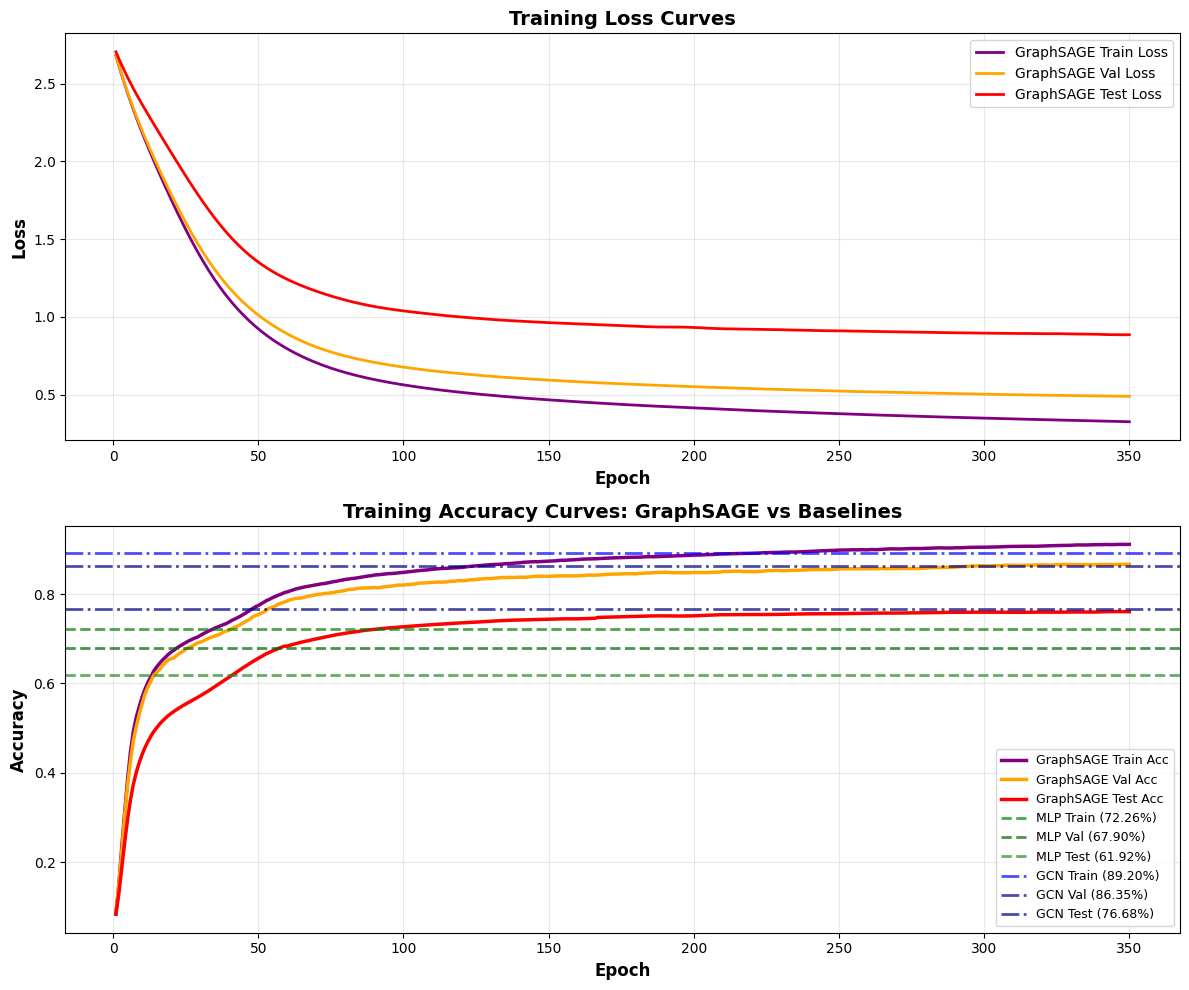

In [18]:
# Load baseline results for comparison
mlp_train_acc = mlp_results['train_accuracy'] if mlp_available else 0.7226
mlp_test_acc = mlp_results['test_accuracy'] if mlp_available else 0.6192
mlp_val_acc = mlp_results['val_accuracy'] if mlp_available else 0.6789

# Load GCN results for comparison
gcn_train_acc = gcn_results['train_accuracy'] if gcn_available else 0.8920
gcn_test_acc = gcn_results['test_accuracy'] if gcn_available else 0.7668
gcn_val_acc = gcn_results['val_accuracy'] if gcn_available else 0.8634

epochs_list = list(range(1, epochs + 1))

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ===== PLOT 1: LOSSES =====
axes[0].plot(epochs_list, train_losses, label='GraphSAGE Train Loss', color='purple', linewidth=2)
axes[0].plot(epochs_list, val_losses, label='GraphSAGE Val Loss', color='orange', linewidth=2)
axes[0].plot(epochs_list, test_losses, label='GraphSAGE Test Loss', color='red', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ===== PLOT 2: ACCURACIES =====
# GraphSAGE curves
axes[1].plot(epochs_list, train_accs, label=f'GraphSAGE Train Acc', color='purple', linewidth=2.5)
axes[1].plot(epochs_list, val_accs, label='GraphSAGE Val Acc', color='orange', linewidth=2.5)
axes[1].plot(epochs_list, test_accs, label='GraphSAGE Test Acc', color='red', linewidth=2.5)

# MLP baseline (horizontal lines)
if mlp_available:
    axes[1].axhline(y=mlp_train_acc, color='green', linestyle='--', linewidth=2, 
                    label=f'MLP Train ({mlp_train_acc*100:.2f}%)', alpha=0.7)
    axes[1].axhline(y=mlp_val_acc, color='darkgreen', linestyle='--', linewidth=2, 
                    label=f'MLP Val ({mlp_val_acc*100:.2f}%)', alpha=0.7)
    axes[1].axhline(y=mlp_test_acc, color='forestgreen', linestyle='--', linewidth=2, 
                    label=f'MLP Test ({mlp_test_acc*100:.2f}%)', alpha=0.7)

# GCN baseline (horizontal lines)
if gcn_available:
    axes[1].axhline(y=gcn_train_acc, color='blue', linestyle='-.', linewidth=2, 
                    label=f'GCN Train ({gcn_train_acc*100:.2f}%)', alpha=0.7)
    axes[1].axhline(y=gcn_val_acc, color='darkblue', linestyle='-.', linewidth=2, 
                    label=f'GCN Val ({gcn_val_acc*100:.2f}%)', alpha=0.7)
    axes[1].axhline(y=gcn_test_acc, color='navy', linestyle='-.', linewidth=2, 
                    label=f'GCN Test ({gcn_test_acc*100:.2f}%)', alpha=0.7)

axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training Accuracy Curves: GraphSAGE vs Baselines', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=9, loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/graphsage/GraphSage_training_curves.png', dpi=300, bbox_inches='tight')
print("\n✅ Training curves saved as 'GraphSage_training_curves.png'")
plt.show()

## 11. Confusion Matrix Analysis


✅ Confusion matrix saved as 'GraphSage_confusion_matrix.png'


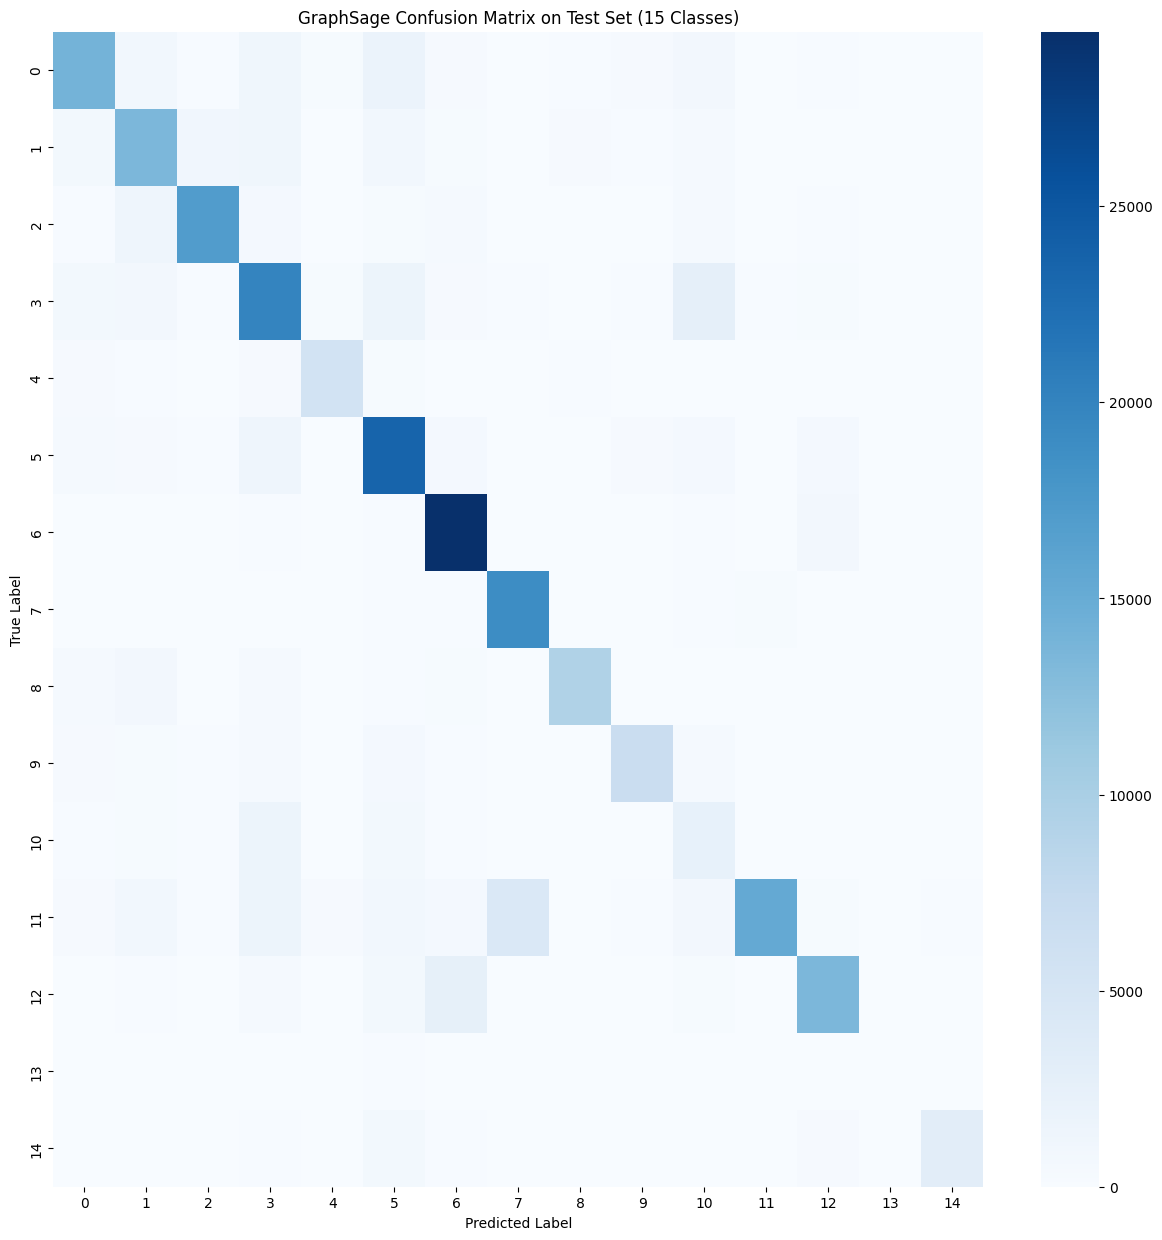

In [19]:
# Compute confusion matrix on test set
model.eval()
with torch.no_grad():
    out = model(X, remapped_edges)
    y_pred = out[test_idx].argmax(dim=-1).cpu().numpy()
    y_true = y_mapped[test_idx].cpu().numpy()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('GraphSage Confusion Matrix on Test Set (15 Classes)')
plt.savefig('images/graphsage/GraphSage_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Confusion matrix saved as 'GraphSage_confusion_matrix.png'")
plt.show()

## 12. Top-k Accuracy Analysis

In [20]:
# Compute top-k accuracy for k in {1, 3, 5}

# mlp_top1_acc = mlp_results['top1_acc'] * 100  if mlp_available else 61.95
# mlp_top3_acc = mlp_results['top3_acc'] * 100 if mlp_available else 84.65
# mlp_top5_acc = mlp_results['top5_acc'] * 100 if mlp_available else 92.14
    
model.eval()
with torch.no_grad():
    out = model(X, remapped_edges)
    probabilities = F.softmax(out[test_idx], dim=-1)
    y_true_tensor = y_mapped[test_idx]

k_values = [1, 3, 5]
topk_accuracies = []

print("\n" + "="*60)
print("TOP-K ACCURACY ANALYSIS")
print("="*60)

for k in k_values:
    _, topk_indices = torch.topk(probabilities, k, dim=-1)
    correct = 0
    for i in range(len(y_true_tensor)):
        if y_true_tensor[i] in topk_indices[i]:
            correct += 1
    acc = correct / len(y_true_tensor)
    topk_accuracies.append(acc)
    print(f"Top-{k} Accuracy: {acc:.4f} ({acc*100:.2f}%)")

# Compare with MLP and GCN
# print("\n📊 COMPARISON WITH MLP:")
# print("Metric        | MLP    | GraphSage")
# print("-" * 40)
# print(f"Top-1 Acc     | {mlp_top1_acc:.2f}% | {topk_accuracies[0]*100:.2f}%")
# print(f"Top-3 Acc     | {mlp_top3_acc:.2f}% | {topk_accuracies[1]*100:.2f}%")
# print(f"Top-5 Acc     | {mlp_top5_acc:.2f}% | {topk_accuracies[2]*100:.2f}%")

# ===== COMPREHENSIVE COMPARISON: MLP vs GCN vs GraphSAGE =====
print("\n" + "="*70)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*70)

if mlp_available and gcn_available:
    # Full 3-way comparison
    print(f"\n{'Metric':<12} | {'MLP':<10} | {'GCN':<10} | {'GraphSAGE':<10} | {'GCN Δ':<8} | {'SAGE Δ':<8}")
    print("-" * 70)
    
    # Top-1 Accuracy
    mlp_top1 = mlp_results['top1_acc'] * 100
    gcn_top1 = gcn_results['top1_acc'] * 100
    sage_top1 = topk_accuracies[0] * 100
    gcn_delta = gcn_top1 - mlp_top1
    sage_delta = sage_top1 - mlp_top1
    print(f"{'Top-1':<12} | {mlp_top1:>9.2f}% | {gcn_top1:>9.2f}% | {sage_top1:>9.2f}% | {gcn_delta:>+7.2f}% | {sage_delta:>+7.2f}%")
    
    # Top-3 Accuracy
    mlp_top3 = mlp_results['top3_acc'] * 100
    gcn_top3 = gcn_results['top3_acc'] * 100
    sage_top3 = topk_accuracies[1] * 100
    gcn_delta = gcn_top3 - mlp_top3
    sage_delta = sage_top3 - mlp_top3
    print(f"{'Top-3':<12} | {mlp_top3:>9.2f}% | {gcn_top3:>9.2f}% | {sage_top3:>9.2f}% | {gcn_delta:>+7.2f}% | {sage_delta:>+7.2f}%")
    
    # Top-5 Accuracy
    mlp_top5 = mlp_results['top5_acc'] * 100
    gcn_top5 = gcn_results['top5_acc'] * 100
    sage_top5 = topk_accuracies[2] * 100
    gcn_delta = gcn_top5 - mlp_top5
    sage_delta = sage_top5 - mlp_top5
    print(f"{'Top-5':<12} | {mlp_top5:>9.2f}% | {gcn_top5:>9.2f}% | {sage_top5:>9.2f}% | {gcn_delta:>+7.2f}% | {sage_delta:>+7.2f}%")
    
    print("="*70)
    
    # Summary
    print("\n🎯 KEY FINDINGS:")
    if sage_top1 > gcn_top1:
        print(f"   ✅ GraphSAGE outperforms GCN by {sage_top1-gcn_top1:+.2f}%")
    elif sage_top1 < gcn_top1:
        print(f"   📊 GCN outperforms GraphSAGE by {gcn_top1-sage_top1:+.2f}%")
    else:
        print(f"   📊 GraphSAGE and GCN perform similarly")
    
    print(f"   ✅ Both GNNs outperform MLP baseline")
    print(f"   📈 Best model: {'GraphSAGE' if sage_top1 >= gcn_top1 else 'GCN'} ({max(sage_top1, gcn_top1):.2f}%)")

elif mlp_available:
    # Only MLP comparison
    print("⚠️  GCN results not available - showing MLP comparison only")
    print(f"\n{'Metric':<12} | {'MLP':<10} | {'GraphSAGE':<10} | {'Δ':<8}")
    print("-" * 50)
    mlp_top1 = mlp_results['top1_acc'] * 100
    sage_top1 = topk_accuracies[0] * 100
    print(f"{'Top-1':<12} | {mlp_top1:>9.2f}% | {sage_top1:>9.2f}% | {sage_top1-mlp_top1:>+7.2f}%")
    
elif gcn_available:
    # Only GCN comparison
    print("⚠️  MLP results not available - showing GCN comparison only")
    print(f"\n{'Metric':<12} | {'GCN':<10} | {'GraphSAGE':<10} | {'Δ':<8}")
    print("-" * 50)
    gcn_top1 = gcn_results['top1_acc'] * 100
    sage_top1 = topk_accuracies[0] * 100
    print(f"{'Top-1':<12} | {gcn_top1:>9.2f}% | {sage_top1:>9.2f}% | {sage_top1-gcn_top1:>+7.2f}%")

else:
    print("⚠️  No baseline results available for comparison")
    print(f"GraphSAGE Top-1 Accuracy: {topk_accuracies[0]*100:.2f}%")

print("="*70)


TOP-K ACCURACY ANALYSIS
Top-1 Accuracy: 0.7606 (76.06%)
Top-3 Accuracy: 0.9164 (91.64%)
Top-5 Accuracy: 0.9574 (95.74%)

📊 COMPREHENSIVE MODEL COMPARISON

Metric       | MLP        | GCN        | GraphSAGE  | GCN Δ    | SAGE Δ  
----------------------------------------------------------------------
Top-1        |     61.95% |     76.68% |     76.06% |  +14.73% |  +14.10%
Top-3        |     84.65% |     92.54% |     91.64% |   +7.89% |   +6.99%
Top-5        |     92.14% |     96.25% |     95.74% |   +4.11% |   +3.60%

🎯 KEY FINDINGS:
   📊 GCN outperforms GraphSAGE by +0.62%
   ✅ Both GNNs outperform MLP baseline
   📈 Best model: GCN (76.68%)



✅ Top-k accuracy curve saved as 'graphsage_topk_accuracy_curve.png'


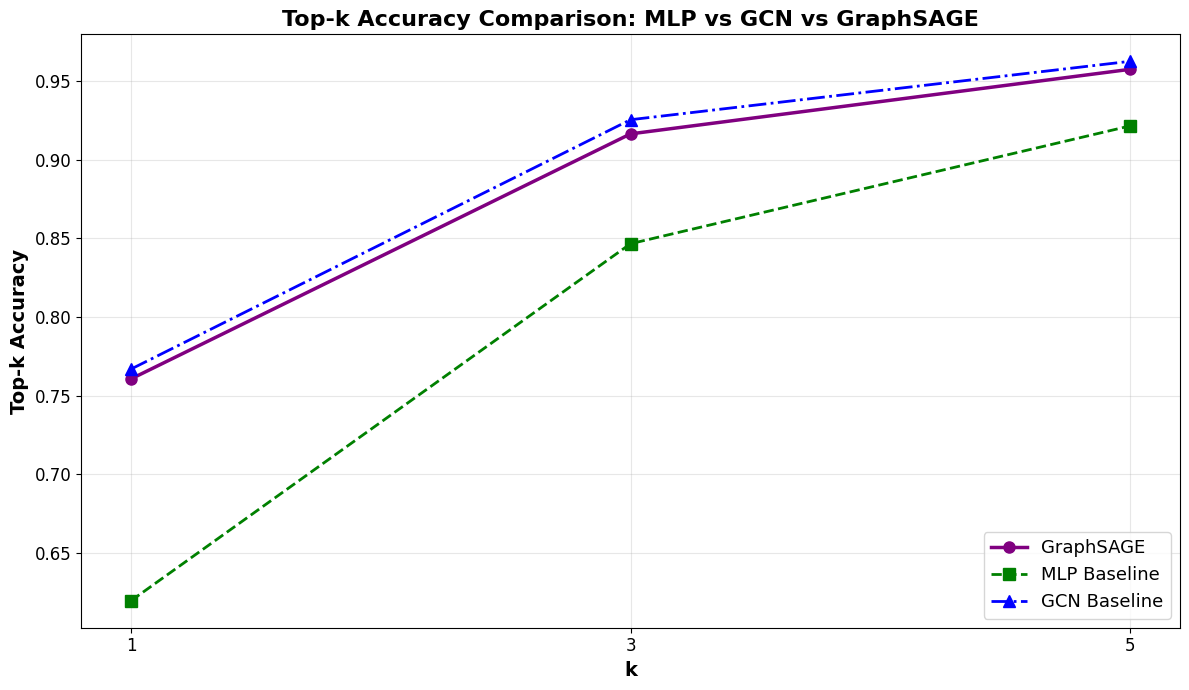

In [21]:
# Plot top-k accuracy curve with all models
plt.figure(figsize=(12, 7))

# GraphSAGE (current model)
plt.plot(k_values, topk_accuracies, marker='o', linestyle='-', color='purple', 
         linewidth=2.5, markersize=8, label='GraphSAGE')

# Add MLP if available
if mlp_available:
    mlp_topk = [mlp_results['top1_acc'], mlp_results['top3_acc'], mlp_results['top5_acc']]
    plt.plot(k_values, mlp_topk, marker='s', linestyle='--', color='green', 
             linewidth=2, markersize=8, label='MLP Baseline')

# Add GCN if available
if gcn_available:
    gcn_topk = [gcn_results['top1_acc'], gcn_results['top3_acc'], gcn_results['top5_acc']]
    plt.plot(k_values, gcn_topk, marker='^', linestyle='-.', color='blue', 
             linewidth=2, markersize=8, label='GCN Baseline')

plt.xlabel('k', fontsize=14, fontweight='bold')
plt.ylabel('Top-k Accuracy', fontsize=14, fontweight='bold')
plt.title('Top-k Accuracy Comparison: MLP vs GCN vs GraphSAGE', fontsize=16, fontweight='bold')
plt.xticks(k_values, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/graphsage/graphsage_topk_accuracy_curve.png', dpi=300, bbox_inches='tight')
print("\n✅ Top-k accuracy curve saved as 'graphsage_topk_accuracy_curve.png'")
plt.show()

## 13. Final Summary and Analysis

In [22]:
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print("\n📊 DATASET:")
print(f"  Total products: {X.shape[0]:,}")
print(f"  Categories: {num_classes}")
print(f"  Co-purchase edges: {remapped_edges.shape[1]:,}")
print(f"  Test set size: {test_idx.shape[0]:,}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"  MLP Baseline:       {mlp_accuracy:.2f}%")
print(f"  GraphSage Baseline:       {best_test_acc*100:.2f}%")
improvement = (best_test_acc - mlp_test_accuracy/100) * 100
print(f"  Absolute Gain:      {improvement:+.2f}%")
relative_improvement = ((best_test_acc - (mlp_test_accuracy/100)) / (mlp_test_accuracy/100)) * 100
print(f"  Relative Gain:      {relative_improvement:+.2f}%")

print("\n⏱️  COMPUTATIONAL COST:")
print(f"  Training time: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"  Time per epoch: {training_time/epochs:.2f}s")

print("\n📈 KEY INSIGHTS:")
if improvement > 0:
    print(f"  ✅ GraphSage outperforms MLP by {improvement:.2f}%")
    print("  ✅ Graph structure provides meaningful signal for product categorization")
    print("  ✅ Co-purchase relationships help improve classification accuracy")
else:
    print(f"  ⚠️  GraphSage underperforms MLP by {abs(improvement):.2f}%")
    print("  ⚠️  Graph structure may not add value for this task")
    print("  ⚠️  Or: More sophisticated GNN architecture/training may be needed")

#print("\n🔬 NEXT STEPS:")
#print("  1. Implement GraphSAGE with neighbor sampling")
#print("  2. Edge perturbation experiments (noise/sparsification)")
#print("  3. Cold-start analysis (low-degree nodes)")
#print("  4. Hyperparameter tuning (layers, hidden dims, learning rate)")
#print("="*70)


FINAL RESULTS SUMMARY

📊 DATASET:
  Total products: 284,290
  Categories: 15
  Co-purchase edges: 2,942,500
  Test set size: 253,624

🎯 MODEL PERFORMANCE:
  MLP Baseline:       61.95%
  GraphSage Baseline:       76.09%
  Absolute Gain:      +14.16%
  Relative Gain:      +22.87%

⏱️  COMPUTATIONAL COST:
  Training time: 128.17s (2.14 min)
  Time per epoch: 0.37s

📈 KEY INSIGHTS:
  ✅ GraphSage outperforms MLP by 14.16%
  ✅ Graph structure provides meaningful signal for product categorization
  ✅ Co-purchase relationships help improve classification accuracy


## 14. Save Results for Comparison

In [23]:
# Save results to file for easy comparison
results = {
    'model': 'GraphSage',
    'test_accuracy': best_test_acc,
    'val_accuracy': best_val_acc,
    'best_epoch': best_epoch,
    'training_time': training_time,
    'num_parameters': sum(p.numel() for p in model.parameters()),
    'top1_acc': topk_accuracies[0],
    'top3_acc': topk_accuracies[1],
    'top5_acc': topk_accuracies[2],
    'hidden_channels': hidden_channels,
    'num_classes': num_classes,
    'num_nodes': X.shape[0],
    'num_edges': remapped_edges.shape[1]
}

with open('GraphSage_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✅ Results saved to 'GraphSage_results.json'")
print("\n📁 Generated files:")
print("  - GraphSage_training_curves.png")
print("  - GraphSage_confusion_matrix.png")
print("  - GraphSage_topk_accuracy_curve.png")
print("  - GraphSage_results.json")



✅ Results saved to 'GraphSage_results.json'

📁 Generated files:
  - GraphSage_training_curves.png
  - GraphSage_confusion_matrix.png
  - GraphSage_topk_accuracy_curve.png
  - GraphSage_results.json
